# SOD314 Project

## Part I

In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
import numpy.random as rd
from tqdm import tqdm

In [8]:
with open('first_database.pkl', 'rb') as f:
    x,y = pickle.load(f)

In [3]:
# Print the number of points in x and y
print("Number of points in x:", len(x))
print("Number of points in y:", len(y))

Number of points in x: 1000000
Number of points in y: 1000000


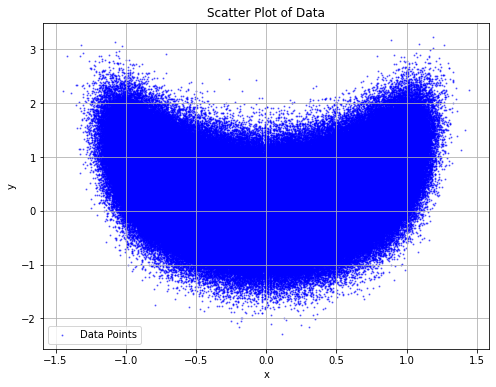

In [4]:
# Create a scatter plot to visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue',s=1, alpha=0.5, label='Data Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Data')
plt.legend()
plt.grid(True)
plt.show()

## Decentralized gradient descent

In [9]:
n=100 # number of data points used for approximation
m=10 # approximation with m=sqrt(n)
a=5 #number of agents

In [10]:
x=x[:n] #select n first points of dataset
print("x :",x)
y=y[:n]
#print("y :",y)
sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = np.array([x[i] for i in ind])
# x_selected =np.linspace(-1,1,m)
#print("x_selected :",x_selected)

x : [-1.         -0.97979798 -0.95959596 -0.93939394 -0.91919192 -0.8989899
 -0.87878788 -0.85858586 -0.83838384 -0.81818182 -0.7979798  -0.77777778
 -0.75757576 -0.73737374 -0.71717172 -0.6969697  -0.67676768 -0.65656566
 -0.63636364 -0.61616162 -0.5959596  -0.57575758 -0.55555556 -0.53535354
 -0.51515152 -0.49494949 -0.47474747 -0.45454545 -0.43434343 -0.41414141
 -0.39393939 -0.37373737 -0.35353535 -0.33333333 -0.31313131 -0.29292929
 -0.27272727 -0.25252525 -0.23232323 -0.21212121 -0.19191919 -0.17171717
 -0.15151515 -0.13131313 -0.11111111 -0.09090909 -0.07070707 -0.05050505
 -0.03030303 -0.01010101  0.01010101  0.03030303  0.05050505  0.07070707
  0.09090909  0.11111111  0.13131313  0.15151515  0.17171717  0.19191919
  0.21212121  0.23232323  0.25252525  0.27272727  0.29292929  0.31313131
  0.33333333  0.35353535  0.37373737  0.39393939  0.41414141  0.43434343
  0.45454545  0.47474747  0.49494949  0.51515152  0.53535354  0.55555556
  0.57575758  0.5959596   0.61616162  0.63636364

If all the data is available in one single location, we can solve for $\alpha^*$
via the optimality conditions, and
$$[\sigma^2K_{mm} + K_{nm}^\top K_{nm} + \nu I]\alpha^* = K_{nm}^\top y$$
Obviously, this can't be done with $n=10^6$ but with our value of $n=100$.

In [11]:
def euclidean_kernel(x, xi):
    return np.exp(-np.linalg.norm(x - xi)**2)

def compute_kernel_matrix(X, Y):
    l = X.shape[0]
    r = Y.shape[0]
    K = np.zeros((l, r))
    for i in range(l):
        for j in range(r):
            K[i, j] = euclidean_kernel(X[i], Y[j])
    return K

def compute_alpha_star(Kmm, Knm, y, sigma_squared, nu):
    m = Kmm.shape[0]
    A = sigma_squared * Kmm + np.dot(Knm.T, Knm) + nu * np.eye(m)
    b = np.dot(Knm.T, y)
    alpha_star = np.linalg.solve(A, b)
    return alpha_star

In [12]:
# Define parameters
sigma = 0.5  # Example value
sigma_squared = 0.25
nu = 1.0  # Regularization parameter

If we consider all 1 million points, we cannot solve the problem exactly with the compute_alpha_star function. We will rather solve the minimization problem 
$$\alpha^* = \argmin_{\alpha \in \R^m}\frac{\sigma^2}{2}\alpha^\top K_{mm}\alpha +\frac{1}{2}
\|y − K_{nm}\alpha\|_2^2 +\frac{\nu}{2}\|\alpha\|_2^2,
$$
This optimisation problem can be solved by $a$ collaborating agents and formulated as the following distributed optimization problem:
$$\alpha^* = \argmin_{\alpha \in \R^m} \sum_{j=1}^a\left[ \frac{\sigma^2}{a}\frac{1}{2}\alpha^\top K_{mm}\alpha +\frac{1}{2}\sum_{i\in A(j)}
\|y_i − K_{(i)m}\alpha\|_2^2 +\frac{\nu}{2a}\|\alpha\|_2^2\right]
=\argmin_{\alpha \in \R^m}\sum_{j=1}^af_j(\alpha),
$$
where we indicated with $i \in A$ the data points that belong to agent $A(j)$, and with $K_{(i)m} =
[k(x_i, x_j )]_{j\in \mathcal{M}}$ of size $1\times m$.


Agent $j$'s gradient can be written as:
$$\R^m \ni \nabla_{\alpha}f_j(\alpha)=  \frac{\sigma^2}{a} K_{mm}\alpha +\sum_{i\in A(j)}K_{(i)m}^\top
( K_{(i)m}\alpha-y_i) +\frac{\nu}{a}\alpha \\
=
\frac{\sigma^2}{a} K_{mm}\alpha +K_{A(j)m}^\top
( K_{A(j)m}\alpha-y_{A(j)}) +\frac{\nu}{a}\alpha
$$
where we denoted $K_{A(j)m} =
[k(x_i, x_l)]_{i\in A(j),l\in \mathcal{M}}$ of size $|A(j)|\times m$. The number of data points of agent $j$, $|A(j)|$ equals in general $n/a$ (here = 100/5=20).

Here, we are not yet in the setup where each agent has its own copy of the target parameter $\alpha$.

In [13]:
def local_objective_function(alpha, sigma_squared, K_mm, y_local, K_im, nu, a):
    term1 = (sigma_squared / a) * (1 / 2) * np.dot(np.dot(alpha.T, K_mm), alpha)
    term2 = (1 / 2) * np.sum((y_local - K_im @ alpha)**2)
    term3 = (nu / (2 * a)) * np.linalg.norm(alpha)**2
    return term1 + term2 + term3

def compute_local_gradient(alpha, sigma_squared, K_mm, y_local, K_im, nu, a):
    # print("alpha local ", alpha)
    # print("K_mm @ alpha",K_mm @ alpha)
    grad = sigma_squared * K_mm @ alpha / a
    # print("K_im.T.shape:",K_im.T.shape)
    # print("(K_im @ alpha - y_local).shape:",(K_im @ alpha - y_local).shape)
    # print("K_im.T @ (K_im @ alpha - y_local) ",K_im.T @ (K_im @ alpha - y_local))
    grad += K_im.T @ (K_im @ alpha - y_local)
    # print("grad.shape:",grad.shape)
    # print("alpha.shape:",alpha.shape)
    # print("(nu / a) * alpha",(nu / a) * alpha)
    grad += (nu / a) * alpha
    return grad

In [14]:
def Nystrom_approx_f(alpha,X_selected,X):
    K1m = compute_kernel_matrix(X,X_selected)
    # print("K1m",K1m.shape)
    # print("alpha.shape",alpha.shape)
    return K1m @ alpha

## Diverse communication graphs between agents

In [15]:
import networkx as nx

def generate_line_graph(a):
    """
    Generate a line graph where each agent communicates only with its immediate neighbors.

    Parameters:
    a (int): Number of agents.

    Returns:
    np.ndarray: Adjacency matrix representing the line graph.
    """
    line_graph = np.zeros((a, a))
    for i in range(a - 1):
        line_graph[i, i + 1] = 1
        line_graph[i + 1, i] = 1
    np.fill_diagonal(line_graph, 1)
    return line_graph

def generate_small_world_graph(a, p=0.1):
    """
    Generate a small-world graph with a specified number of agents and probability of rewiring.

    Parameters:
    a (int): Number of agents.
    p (float): Probability of rewiring.

    Returns:
    np.ndarray: Adjacency matrix representing the small-world graph.
    """
    small_world_graph = nx.watts_strogatz_graph(a, 2, p)
    small_world_graph=nx.to_numpy_array(small_world_graph)
    np.fill_diagonal(small_world_graph, 1)
    return small_world_graph

def generate_fully_connected_graph(a):
    """
    Generate a fully connected graph where each agent communicates with every other agent directly.

    Parameters:
    a (int): Number of agents.

    Returns:
    np.ndarray: Adjacency matrix representing the fully connected graph.
    """
    return np.ones((a, a)) /a

def generate_cycle_graph(a):
    """
    Generate a cycle graph where each agent communicates with its two adjacent agents forming a cycle.

    Parameters:
    a (int): Number of agents.

    Returns:
    np.ndarray: Adjacency matrix representing the cycle graph.
    """
    cycle_graph = np.zeros((a, a))
    for i in range(a):
        cycle_graph[i, (i - 1) % a] = 1  # Left neighbor
        cycle_graph[i, (i + 1) % a] = 1  # Right neighbor
    np.fill_diagonal(cycle_graph,1)
    return cycle_graph

def renormalize_graph(graph):
    """
    Renormalize the given graph to make it doubly stochastic.

    Parameters:
    graph (np.ndarray): Adjacency matrix representing the graph.

    Returns:
    np.ndarray: Doubly stochastic matrix obtained by renormalizing the input graph.
    """
    row_sums = np.sum(graph, axis=1)
    print("row_sums:",row_sums)
    graph = graph / row_sums[:, np.newaxis]
    # print("row normalized graph",graph)
    col_sums = np.sum(graph, axis=0)
    print("col_sums:",col_sums)
    graph = graph / col_sums[np.newaxis,:]
    return graph

In [16]:
# Generate communication graphs
fully_connected_graph = generate_fully_connected_graph(a)
fc_graph = renormalize_graph(fully_connected_graph)
print("normalized_fully_connected_graph:",fc_graph)

line_graph = generate_line_graph(a)
print("line_graph:",line_graph)
line_graph=renormalize_graph(line_graph)
print("normalized_line_graph:",line_graph)

small_world_graph = generate_small_world_graph(a, p=0.1)
print("small_world_graph:",small_world_graph)
small_world_graph=renormalize_graph(small_world_graph)
print("normalized small_world_graph:",small_world_graph)

cycle_graph = generate_cycle_graph(a)
cycle_graph = renormalize_graph(cycle_graph)
print("normalized_cycle_graph:",cycle_graph)

row_sums: [1. 1. 1. 1. 1.]
col_sums: [1. 1. 1. 1. 1.]
normalized_fully_connected_graph: [[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]
line_graph: [[1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]]
row_sums: [2. 3. 3. 3. 2.]
col_sums: [0.83333333 1.16666667 1.         1.16666667 0.83333333]
normalized_line_graph: [[0.6        0.42857143 0.         0.         0.        ]
 [0.4        0.28571429 0.33333333 0.         0.        ]
 [0.         0.28571429 0.33333333 0.28571429 0.        ]
 [0.         0.         0.33333333 0.28571429 0.4       ]
 [0.         0.         0.         0.42857143 0.6       ]]
small_world_graph: [[1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1.]]
row_sums: [3. 3. 3. 3. 3.]
col_sums: [1. 1. 1. 1. 1.]
normalized small_world_graph: [[0.33333333 0.33333333 0.         0.         0.33333333]
 [0.33333333 0.33333333 0.3333333

## Decentralized Gradient Descent

Here is the pseudo-code for DGD:
- Start with $\alpha^i_0 \in \R^n$ at each device $i$
- Iterate: ask every device: $\alpha^i_{k+1} = \sum_{j=1}^a w_{ij}\alpha^j_k- s_k\nabla f_i(\alpha^i_k), \forall i \in \{1,\dots,a\}$

Here $w_{ij} = 0$ if device i and j are not connected, that is $\sum_{j=1}^a w_{ij}\alpha^j_k = w_{ii}\alpha^i_k + \sum_{j\in N_i} w_{ij}\alpha^j_k$ and the step size at iteration $k$ is $s_k$.

Practically, communication needs to happen synchronously and bi-directionally and we are giving a copy of $\alpha$ to each device and looking at the iterates $\alpha = [\alpha^1;\dots;\alpha^a]$ and
$$
\alpha_{k+1} = \textbf{W}\alpha_{k} -s_k \nabla_{\alpha} F(\alpha_k ), \quad F (\alpha) := \sum_{j=1}^af_j(\alpha^j),$$
where matrix $W = [W_{ij}]$ is the collection of the weights, it is assumed doubly stochastic and it is the mixing matrix. And $\textbf{W} = W \otimes I_n \in \R^{am\times am}$.

We plot the optimality gap of agent $i$'s parameter at iteration $k$, which equals $\|\alpha^i_k - \alpha^*\|$, in a log-log plot.

In [13]:
def decentralized_gradient_descent(X, X_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, W):
    m = X_selected.shape[0]
    n = X.shape[0]
    agents_data_indices = np.array_split(np.random.permutation(n), a)
    # each agent should have n/a=100/5=20 points
    #print("agents_data_indices:",agents_data_indices)
    alpha = np.ones((m * a, 1))  # Initialize local variables for each agent
    all_optimality_gaps = [[] for _ in range(a)]  # Store optimality gaps for each agent
    all_alpha = []  # Store alpha at each iteration
    
    # Create mixing matrix from communication matrix
    mixing_matrix = np.kron(W, np.eye(m))  # Mixing matrix
    
    # Compute kernel matrices
    K_mm = compute_kernel_matrix(X_selected, X_selected)
    #print("K_mm",K_mm)
    #Knm = compute_kernel_matrix(X, X_selected)
    #print("Knm ",Knm)
    
    for iter in tqdm(range(num_iterations)):
        #print("iter:",iter)
        
        # Append current alpha to the list
        all_alpha.append(alpha)
        
        all_gradients = np.zeros((m * a, 1))
        
        # Compute gradients for all agents
        for agent_idx, data_indices in enumerate(agents_data_indices):
            # Select data and compute local variables
            X_local = X[data_indices]
            y_local = y[data_indices].reshape(-1, 1)
            K_im = compute_kernel_matrix(X_local, X_selected)
            
            # Compute local gradient on local copy of alpha
            grad_local = compute_local_gradient(alpha[m * agent_idx: m * (agent_idx + 1)], sigma_squared, K_mm, y_local, K_im, nu, a)
            all_gradients[m * agent_idx: m * (agent_idx + 1)] = grad_local
        
        # Update alpha simultaneously for all agents

        alpha = mixing_matrix @ alpha - step_size * all_gradients
        
        # Compute and store optimality gaps for each agent
        for agent_idx in range(a):
            alpha_agent = alpha[m * agent_idx: m * (agent_idx + 1)].reshape(-1, 1)
            optimality_gap = np.linalg.norm(alpha_agent - alpha_star.reshape(-1, 1))
            all_optimality_gaps[agent_idx].append(optimality_gap)
        
    return all_optimality_gaps, all_alpha


In [23]:
num_iterations = 20000
# ESSENTIAL: must be small enough
step_size = 0.002

# Compute alpha_star
K_mm = compute_kernel_matrix(x_selected, x_selected)
Knm = compute_kernel_matrix(x, x_selected)
alpha_star = compute_alpha_star(K_mm, Knm, y, sigma_squared, nu)
print("alpha_star.shape:",alpha_star.shape)
print("alpha_star ",alpha_star)

alpha_star.shape: (10,)
alpha_star  [ 0.31906421  1.0187085   0.41338337  0.80418618 -0.54589683 -0.51794802
 -0.48338483  0.55753341 -0.36059458 -0.35272759]


In [15]:
# Call decentralized gradient descent with different communication graphs
optimality_gap_fc,alpha_fc = decentralized_gradient_descent(x, x_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, fc_graph)
print("fully connected graph done")
optimality_gap_line,alpha_line = decentralized_gradient_descent(x, x_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star,line_graph)
print("line graph done")
optimality_gap_small_world,alpha_small_world = decentralized_gradient_descent(x, x_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, small_world_graph)
print("small world graph done")
optimality_gap_cycle,alpha_cycle = decentralized_gradient_descent(x, x_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, cycle_graph)
print("cycle graph done")

  4%|▍         | 878/20000 [00:04<01:29, 212.95it/s]


KeyboardInterrupt: 

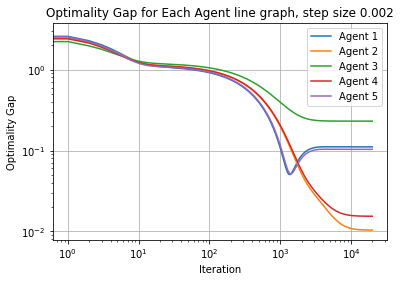

In [ ]:
# Plot optimality gaps for each agent
for agent_idx, optimality_gaps in enumerate(optimality_gap_line):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'Optimality Gap for Each Agent line graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

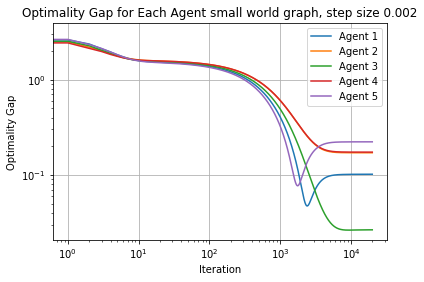

In [ ]:
# Plot optimality gaps for each agent
for agent_idx, optimality_gaps in enumerate(optimality_gap_small_world):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'Optimality Gap for Each Agent small world graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

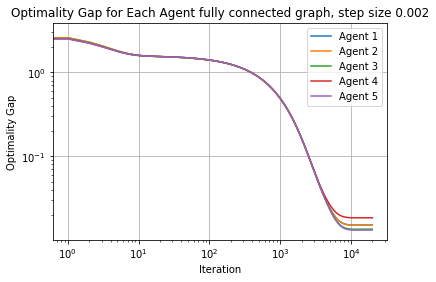

In [ ]:
# Plot optimality gaps for each agent
for agent_idx, optimality_gaps in enumerate(optimality_gap_fc):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'Optimality Gap for Each Agent fully connected graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

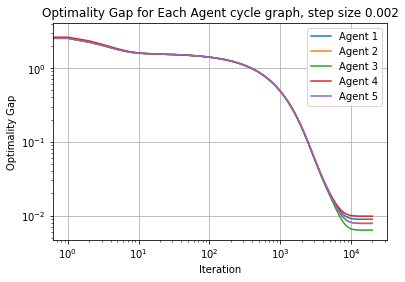

In [ ]:
# Plot optimality gaps for each agent
for agent_idx, optimality_gaps in enumerate(optimality_gap_cycle):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'Optimality Gap for Each Agent cycle graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

### Test reconstruction

In [16]:
nt=250
x_prime=np.linspace(-1,1,nt)
ag_idx1 = 0 # between 0 and 4
iter1 = 100
ag_idx2 = 0 # between 0 and 4
iter2 = 4000
alpha_agent_fc1 = alpha_fc[iter1][ag_idx1*m:(ag_idx1+1)*m]
alpha_agent_fc2 = alpha_fc[iter2][ag_idx2*m:(ag_idx2+1)*m]
# print("alpha_agent_fc.shape",alpha_agent_fc.shape)
reconstruction_fc1=Nystrom_approx_f(alpha_agent_fc1,x_selected,x_prime)
reconstruction_fc2=Nystrom_approx_f(alpha_agent_fc2,x_selected,x_prime)
reconstruction_centralized = Nystrom_approx_f(alpha_star,x_selected,x_prime)

NameError: name 'alpha_fc' is not defined

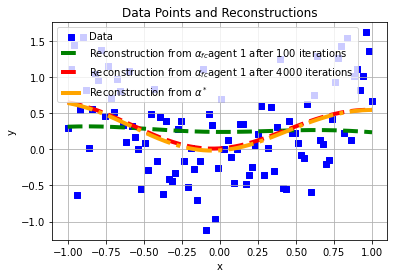

In [ ]:
# Plot data points used for DGD with squares
plt.scatter(x, y, color='blue', marker='s', label='Data')

# Plot reconstructions with thicker lines
plt.plot(x_prime, reconstruction_fc1, color='green', linestyle='--', linewidth=4, label=r'Reconstruction from $\alpha_{fc}$'+f'agent {ag_idx1+1} after {iter1} iterations')
plt.plot(x_prime, reconstruction_fc2, color='red', linestyle='--', linewidth=4, label=r'Reconstruction from $\alpha_{fc}$'+f'agent {ag_idx2+1} after {iter2} iterations')
plt.plot(x_prime, reconstruction_centralized, color='orange', linestyle='-.', linewidth=4, label=r'Reconstruction from $\alpha^*$')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Data Points and Reconstructions')
plt.legend()
plt.grid(True)
plt.show()

### Justificating stepsize DGD

- We define the Adjacency matrix as $A \in {0, 1}^{|V|×|V|}$, with 1 entries if node i and j share an edge.
- The Laplacian matrix of a undirected graph $G$ is an $|V| × |V|$ symmetric matrix defined by
$L_G = D − A$,where $D =\textrm{diag}(d_1,\dots, d_n)$ is the degree matrix, which is the diagonal matrix formed from the vertex degrees.
- The vertex degree $d_i$ is the number of neighbors the node i has. Therefore, $L_G\mathbf{1} = 0$.
- A doubly stochastic matrix $W$ is a matrix for which, each entry is non-negative, and $W\mathbf{1} = \mathbf{1}$, and $\mathbf{1}^\top W = \mathbf{1}^\top$.

We assume that the mixing matrix $W = [w_{ij}]$ is symmetric and doubly stochastic.
- The eigenvalues of $W$ are real and lie in the unit disk; they can be sorted in a nonincreasing order
$$1 = \lambda_1(W) \geq \lambda_2(W) \geq \dots \geq \lambda_a(W) \geq −1.$$
Let the second largest magnitude of the eigenvalues of W be denoted as
$$\gamma = \max{|\lambda_2(W)|, |\lambda_a(W)|}$$
- Example: $W = I −\frac{1}{\max(d_i)+\mathbf{1}L_G}$ is doubly-stochastic.


## Gradient tracking

Pseudo-Code for Gradient tracking:

- Initialize $\alpha^k$, $g_i^k$.
- $\alpha_i^{k+1} = \sum_{j=1}^{N} w_{ij}\alpha_j^k - g_i^k, \quad \forall i$
- $g_i^{k+1} = \sum_{j=1}^{N} w_{ij}g_j^k + (\nabla f_i (\alpha_i^{k+1}) - \nabla f_i (\alpha_i^k)), \quad \forall i$

Le gradient tracking peut être vu comme une fonction de $y = [\alpha_1; \ldots ; \alpha_N]$ et $q = [g_1; \ldots ; g_N]$, 
- $y^{k+1} = W y^k - g^k$ 
- $q^{k+1} = W q^k + \nabla y F (y^{k+1}) - \nabla y F (y^k)$



In [17]:
def decentralized_gradient_tracking(X, X_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, W):
    m = X_selected.shape[0]
    n = X.shape[0]
    agents_data_indices = np.array_split(np.random.permutation(n), a)
    # each agent should have n/a=100/5=20 points
    #print("agents_data_indices:",agents_data_indices)
    alpha = np.ones((m * a, 1))  # Initialize local variables for each agent
    all_optimality_gaps = [[] for _ in range(a)]  # Store optimality gaps for each agent
    all_alpha = []  # Store alpha at each iteration
    gradient_tracker = np.zeros((m * a, 1))  # Initialize gradient tracker
    
    # Create mixing matrix from communication matrix
    mixing_matrix = np.kron(W, np.eye(m))  # Mixing matrix
    
    # Compute kernel matrices
    K_mm = compute_kernel_matrix(X_selected, X_selected)
    #print("K_mm",K_mm)
    Knm = compute_kernel_matrix(X, X_selected)
    #print("Knm ",Knm)
    grad0 = np.zeros((m * a, 1))
    grad1 =  np.zeros((m * a, 1)) #store the two last gradients for all agents
    for iter in tqdm(range(num_iterations)):
        #print("iter:",iter)
        
        # Append current alpha to the list
        all_alpha.append(alpha)
        
        all_gradients = np.zeros((m * a, 1))
        
        # Compute gradients for all agents
        for agent_idx, data_indices in enumerate(agents_data_indices):
            # Select data and compute local variables
            X_local = X[data_indices]
            y_local = y[data_indices].reshape(-1, 1)
            K_im = compute_kernel_matrix(X_local, X_selected)
            
            # Compute local gradient on local copy of alpha
            grad_local = compute_local_gradient(alpha[m * agent_idx: m * (agent_idx + 1)], sigma_squared, K_mm, y_local, K_im, nu, a)
            all_gradients[m * agent_idx: m * (agent_idx + 1)] = grad_local
        grad0 = grad1
        grad1 = all_gradients
         # Gradient tracking update
        gradient_tracker = mixing_matrix @ gradient_tracker + grad1 - grad0
        # Update alpha using the gradient tracker
        alpha = mixing_matrix @ alpha - step_size * gradient_tracker
        
        # Compute and store optimality gaps for each agent
        for agent_idx in range(a):
            alpha_agent = alpha[m * agent_idx: m * (agent_idx + 1)].reshape(-1, 1)
            optimality_gap = np.linalg.norm(alpha_agent - alpha_star.reshape(-1, 1))
            all_optimality_gaps[agent_idx].append(optimality_gap)
        
    return all_optimality_gaps, all_alpha


100%|██████████| 20000/20000 [01:26<00:00, 230.52it/s]


all graphs done


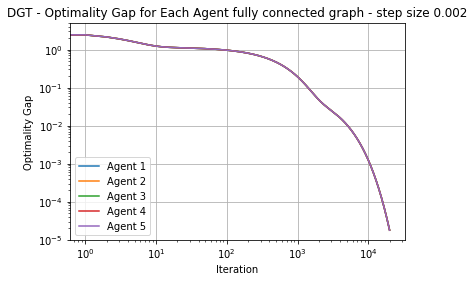

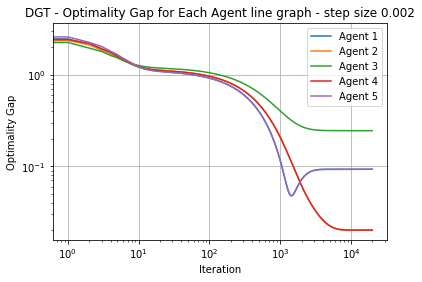

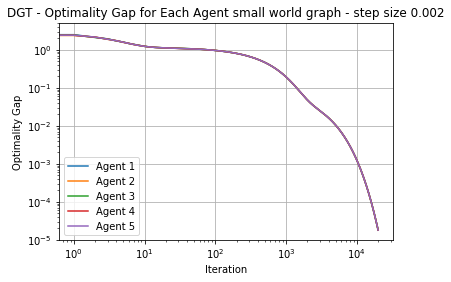

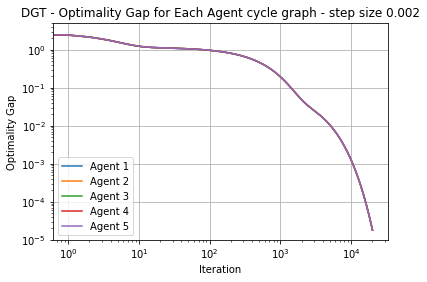

In [ ]:
# Call decentralized gradient tracking with different communication graphs
optimality_gap_fc,alpha_fc = decentralized_gradient_tracking(x, x_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, fc_graph)
#print("fully connected graph done")
optimality_gap_line,alpha_line = decentralized_gradient_tracking(x, x_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star,line_graph)
#print("line graph done")
optimality_gap_small_world,alpha_small_world = decentralized_gradient_tracking(x, x_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, small_world_graph)
#print("small world graph done")
optimality_gap_cycle,alpha_cycle = decentralized_gradient_tracking(x, x_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, cycle_graph)
#print("cycle graph done")
print("all graphs done")

for agent_idx, optimality_gaps in enumerate(optimality_gap_fc):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")
plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'DGT - Optimality Gap for Each Agent fully connected graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()
for agent_idx, optimality_gaps in enumerate(optimality_gap_line):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'DGT - Optimality Gap for Each Agent line graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

for agent_idx, optimality_gaps in enumerate(optimality_gap_small_world):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'DGT - Optimality Gap for Each Agent small world graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()
for agent_idx, optimality_gaps in enumerate(optimality_gap_cycle):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'DGT - Optimality Gap for Each Agent cycle graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

## Dual Decomposition

In [47]:
def step(b, Kmm, Knm, Knmy, nu, sigma_squared):
    m = Kmm.shape[0]
    A = (1/5)*sigma_squared * Kmm + Knm + (nu/5) * np.eye(m)
    b_ = Knmy - b
    alpha_star_i = np.linalg.solve(A, b_)
    return alpha_star_i

In [48]:
def create_lamb(a, m):
    lamb = {}
    for i in range(a):
        for j in range(a):
            if i > j:
                #lamb[(i,j)] = np.random.rand(m).reshape(m,1)
                lamb[(i,j)] = np.zeros(m).reshape(m,1)
    return(lamb)

In [49]:
def term_sup(lam, W, m, i):
    a = W.shape[0]
    res = np.zeros((m,1))
    for j in range(a):
        if W[i,j] > 0:
            if i > j:
                res += lam[i,j]
            elif j > i:
                res -=  lam[j,i]
    return(res)

In [57]:
def dual_decomposition(X, X_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, W):
    m = X_selected.shape[0]
    n = X.shape[0]
    agents_data_indices = np.array_split(np.random.permutation(n), a)
    # each agent should have n/a=100/5=20 points
    #print("agents_data_indices:",agents_data_indices)
    alpha = [np.zeros((m, 1)) for _ in range(a)]  # Initialize local variables for each agent
    all_optimality_gaps = [[] for _ in range(a)]  # Store optimality gaps for each agent
    all_alpha = [[] for _ in range(a)]  # Store alpha at each iteration
    lamb = create_lamb(a, m)
    K_mm = compute_kernel_matrix(X_selected, X_selected)
    #Knm = compute_kernel_matrix(X, X_selected)
    for k in tqdm(range(num_iterations)):
        for agent_idx, data_indices in enumerate(agents_data_indices):
            # Select data and compute local variables
            X_local = X[data_indices]
            y_local = y[data_indices].reshape(-1, 1)
            K_im = np.zeros((m,m))
            K_imy = np.zeros((m,1))
            for j in range(len(X_local)):
                K_jm = compute_kernel_matrix(np.array([X_local[j]]), X_selected)
                K_jmy = y_local[j]*K_jm.T
                KK_im = np.dot(K_jm.T, K_jm)
                K_im += KK_im
                K_imy += K_jmy
            b = term_sup(lamb, W, m, agent_idx)
            #print(b)
            sol = step(b, K_mm, K_im, K_imy, nu, sigma_squared)
            alpha[agent_idx] = sol
        for i in range(a):
            for j in range(i):
                lamb[i,j] += step_size[k]*(alpha[i] - alpha[j])
        for agent_idx in range(a):
            alpha_agent = alpha[agent_idx]
            optimality_gap = np.linalg.norm(alpha_agent - alpha_star.reshape(-1, 1))
            all_optimality_gaps[agent_idx].append(optimality_gap)
            all_alpha[agent_idx].append(alpha_agent)

    return all_optimality_gaps, all_alpha

100%|██████████| 20000/20000 [01:37<00:00, 204.55it/s]


all graphs done


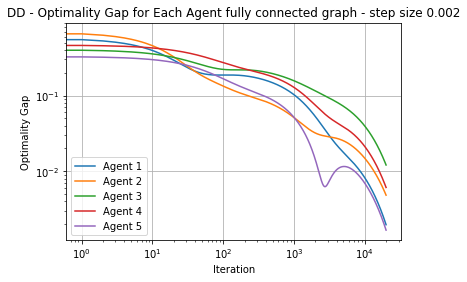

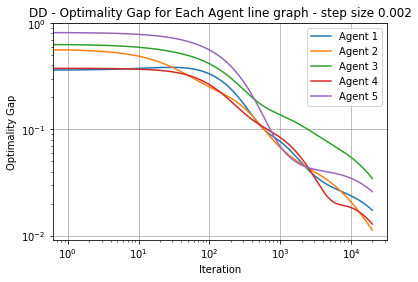

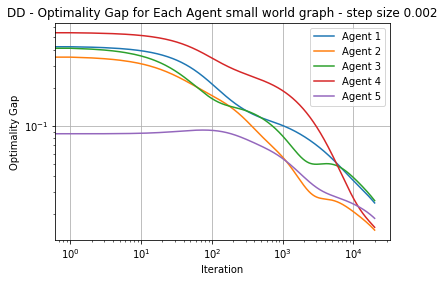

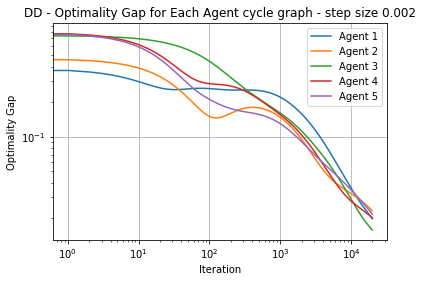

In [60]:
s = [0.002 for _ in range(20000)]
# Call decentralized gradient tracking with different communication graphs
optimality_gap_fc,alpha_fc = dual_decomposition(x, x_selected, y, sigma_squared, nu, a, num_iterations, s, alpha_star, fc_graph)
#print("fully connected graph done")
optimality_gap_line,alpha_line = dual_decomposition(x, x_selected, y, sigma_squared, nu, a, num_iterations, s, alpha_star,line_graph)
#print("line graph done")
optimality_gap_small_world,alpha_small_world = dual_decomposition(x, x_selected, y, sigma_squared, nu, a, num_iterations, s, alpha_star, small_world_graph)
#print("small world graph done")
optimality_gap_cycle,alpha_cycle = dual_decomposition(x, x_selected, y, sigma_squared, nu, a, num_iterations, s, alpha_star, cycle_graph)
#print("cycle graph done")
print("all graphs done")

for agent_idx, optimality_gaps in enumerate(optimality_gap_fc):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")
plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'DD - Optimality Gap for Each Agent fully connected graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()
for agent_idx, optimality_gaps in enumerate(optimality_gap_line):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'DD - Optimality Gap for Each Agent line graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

for agent_idx, optimality_gaps in enumerate(optimality_gap_small_world):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'DD - Optimality Gap for Each Agent small world graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()
for agent_idx, optimality_gaps in enumerate(optimality_gap_cycle):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'DD - Optimality Gap for Each Agent cycle graph - step size {step_size}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

## ADMM

In [70]:
beta = 10

In [63]:
def create_lamb_gam(a, m):
    lamb = {}
    gam = {}
    for i in range(a):
        for j in range(a):
            lamb[(i,j)] = np.zeros(m).reshape(m,1)
            gam[(i,j)] =  np.random.rand(m).reshape(m,1)
    return(lamb, gam)

In [64]:
def step2(b,c, Kmm, Knm,Knmy, nu, sigma_squared):
    m = Kmm.shape[0]
    A = (1/5)*sigma_squared * Kmm + Knm + ((nu/5) +c) * np.eye(m)
    b_ = Knmy - b
    alpha_star_i = np.linalg.solve(A, b_)
    return alpha_star_i

In [65]:
def term_sup2(gam, lamb, beta, W, i):
    c = 0
    b = 0
    a = W.shape[0]
    for j in range(a):
        if W[i,j] > 0:
            c += beta
            b += lamb[i,j] - beta*gam[i,j]
    return b, c

In [66]:
def ADMM(X, X_selected, y, sigma_squared, nu, a, num_iterations, beta, alpha_star, W):
    m = X_selected.shape[0]
    n = X.shape[0]
    agents_data_indices = np.array_split(np.random.permutation(n), a)
    # each agent should have n/a=100/5=20 points
    #print("agents_data_indices:",agents_data_indices)
    alpha = [np.ones((m, 1)) for _ in range(a)]  # Initialize local variables for each agent
    all_optimality_gaps = [[] for _ in range(a)]  # Store optimality gaps for each agent
    all_alpha = [[] for _ in range(a)]  # Store alpha at each iteration
    lamb, gam = create_lamb_gam(a, m)
    K_mm = compute_kernel_matrix(X_selected, X_selected)
    #Knm = compute_kernel_matrix(X, X_selected)
    for _ in tqdm(range(num_iterations)):
        for agent_idx, data_indices in enumerate(agents_data_indices):
            # Select data and compute local variables
            X_local = X[data_indices]
            y_local = y[data_indices].reshape(-1, 1)
            K_im = np.zeros((m,m))
            K_imy = np.zeros((m,1))
            for j in range(len(X_local)):
                K_jm = compute_kernel_matrix(np.array([X_local[j]]), X_selected)
                K_jmy = y_local[j]*K_jm.T
                KK_im = np.dot(K_jm.T, K_jm)
                K_im += KK_im
                K_imy += K_jmy
            b, c = term_sup2(gam, lamb,beta, W, agent_idx)
            sol = step2(b,c, K_mm, K_im, K_imy, nu, sigma_squared)
            alpha[agent_idx] = sol
        for i in range(a):
            for j in range(a):
                gam[i,j] = (1/2)*(alpha[i] + alpha[j])
                lamb[i,j] += beta*(alpha[i] - gam[i,j])
        for agent_idx in range(a):
            alpha_agent = alpha[agent_idx]
            optimality_gap = np.linalg.norm(alpha_agent - alpha_star.reshape(-1, 1))
            all_optimality_gaps[agent_idx].append(optimality_gap)
            all_alpha[agent_idx].append(alpha_agent)

    return all_optimality_gaps, all_alpha

100%|██████████| 20000/20000 [01:57<00:00, 170.68it/s]


all graphs done


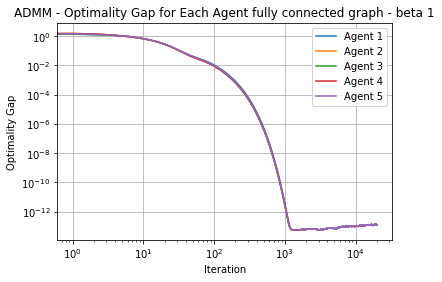

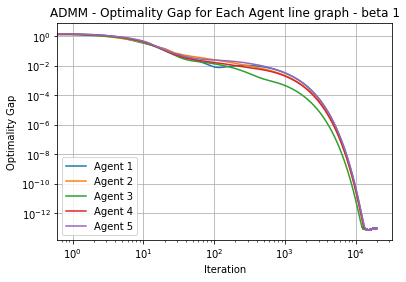

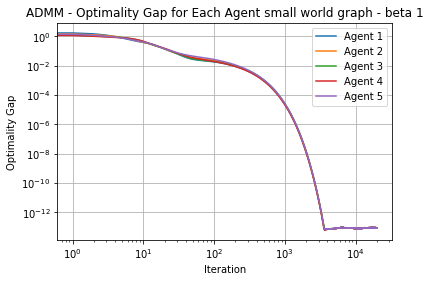

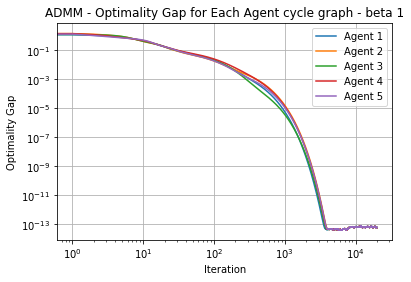

In [46]:

optimality_gap_fc,alpha_fc = ADMM(x, x_selected, y, sigma_squared, nu, a, num_iterations, beta, alpha_star, fc_graph)
#print("fully connected graph done")
optimality_gap_line,alpha_line = ADMM(x, x_selected, y, sigma_squared, nu, a, num_iterations, beta, alpha_star,line_graph)
#print("line graph done")
optimality_gap_small_world,alpha_small_world = ADMM(x, x_selected, y, sigma_squared, nu, a, num_iterations, beta, alpha_star, small_world_graph)
#print("small world graph done")
optimality_gap_cycle,alpha_cycle = ADMM(x, x_selected, y, sigma_squared, nu, a, num_iterations, beta, alpha_star, cycle_graph)
#print("cycle graph done")
print("all graphs done")
for agent_idx, optimality_gaps in enumerate(optimality_gap_fc):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")
plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'ADMM - Optimality Gap for Each Agent fully connected graph - beta {beta}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

for agent_idx, optimality_gaps in enumerate(optimality_gap_line):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'ADMM - Optimality Gap for Each Agent line graph - beta {beta}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

for agent_idx, optimality_gaps in enumerate(optimality_gap_small_world):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'ADMM - Optimality Gap for Each Agent small world graph - beta {beta}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

for agent_idx, optimality_gaps in enumerate(optimality_gap_cycle):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title(f'ADMM - Optimality Gap for Each Agent cycle graph - beta {beta}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

## PART II

In [47]:
def objective_function(x, y, X_selected, alpha, nu, sigma_squared, a):
    res = 0
    K_mm = compute_kernel_matrix(X_selected, X_selected)
    for i in range(5):
        x_ = x[i]
        y_ = y[i]
        term1 = (sigma_squared / (2*a)) * np.dot(np.dot(alpha.T, K_mm), alpha)
        term2 = 0
        for j in range(len(x_)):
            term2 += (1/2)*(np.linalg.norm(y_[j] - compute_kernel_matrix(np.array([x_[j]]), x_selected))**2)
        term3 = (nu / (2 * a)) * np.linalg.norm(alpha)**2
        res+= term1 + term2 + term3
    return res  

In [48]:
with open('second_database.pkl', 'rb') as f:
    X, Y = pickle.load(f)

In [49]:
x_m_points=np.linspace(-1,1,m)

In [50]:
X = np.asarray(X)
Y = np.asarray(Y)

In [51]:
f_star = objective_function(X, Y, x_m_points, alpha_star, nu, sigma_squared, a)

In [52]:
def client_update(X_selected, E, al_0, Kmm, batchs_x, batchs_y, nu, sigma_squared, step_size):
    al = al_0
    for k in range(E):
        grad = (1/5)*np.dot(Kmm, al) + (nu/5)*al
        for j in range(len(batchs_x)):
            Kjm = compute_kernel_matrix(batchs_x[j], X_selected)
            y = batchs_y[j].reshape(-1,1)
            #print(al.shape, grad.shape, Kjm.shape, batchs_y[j].shape)
            grad -= (1/sigma_squared)*np.dot(Kjm.T, (y - np.dot(Kjm,al)))
        al -= step_size[k]*grad
    return al

In [53]:
def FedAVg(B, C, E, X_selected, X_, Y_, sigma_squared, nu, a, step_size, f_star, num_iterations):
    m = X_selected.shape[0]
    # each agent should have n/a=100/5=20 points
    alpha = [np.ones((m, 1)) for _ in range(a)]
    all_optimality_gaps = []
    all_alpha = [] 
    K_mm = compute_kernel_matrix(X_selected, X_selected)
    for k in tqdm(range(num_iterations)):
        C_ = np.random.choice(range(a), C, replace=True)
        for i in C_:
            al_0 = alpha[i]
            x = X_[i].reshape(-1,1)
            y = Y_[i].reshape(-1,1)
            number_of_point = len(x)
            #print(B, number_of_point)
            #if B == number_of_point:
            #K_jm = compute_kernel_matrix(X_[i], X_selected)
            conc = np.concatenate([x, y], axis = 1)
            spl = np.array_split(conc, number_of_point//B)
            batchs_x = [spl[j][:,0] for j in range(len(spl))]
            batchs_y = [spl[j][:,1] for j in range(len(spl))]
            #print(batchs_x)
            al_E = client_update(X_selected, E, al_0, K_mm, batchs_x, batchs_y, nu, sigma_squared, step_size[k:])
            alpha[i] = al_E
        res = (1/C)*np.sum(alpha, axis=0)
        for i in range(a):
            alpha[i] = res
        all_alpha.append(res)
        f = objective_function(X_, Y_, X_selected, res, nu, sigma_squared, a)
        all_optimality_gaps.append((abs(f_star - f))[0])
    #ec = np.linalg.norm(res - alpha_star.reshape(-1, 1))
    return all_optimality_gaps, all_alpha

100%|██████████| 10000/10000 [40:52<00:00,  4.08it/s]


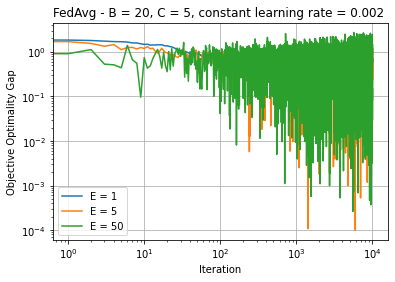

 75%|███████▍  | 7487/10000 [01:31<00:30, 81.67it/s]


KeyboardInterrupt: 

In [55]:
#different parameters
def step_const(_, step_size=0.002):
    return step_size

def diminishing_step(k):
    return(0.002/(1+0.01*k))

s = [0.002 for i in range(15000)]
d = [(0.002/(1+0.01*k)) for k in range(15000)]

B = 20
C = 5
E = [1, 5, 50]
optimality_gap = [FedAVg(B, C, E[i], x_m_points, X, Y, sigma_squared, nu, a, s, f_star, 10000)[0] for i in range(3)]

for i, optimality_gaps in enumerate(optimality_gap):
    plt.plot(range(10000), optimality_gaps, label=f"E = {E[i]}")
plt.xlabel('Iteration')
plt.ylabel('Objective Optimality Gap')
plt.title(f'FedAvg - B = {B}, C = {C}, constant learning rate = 0.002 ')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

optimality_gap2 = [FedAVg(B, C, E[i], x_m_points, X, Y, sigma_squared, nu, a, d, f_star, 10000)[0] for i in range(3)]

for i, optimality_gaps in enumerate(optimality_gap2):
    plt.plot(range(10000), optimality_gaps, label=f"E = {E[i]}")
plt.xlabel('Iteration')
plt.ylabel('Objective Optimality Gap')
plt.title(f'FedAvg - B = {B}, C = {C}, diminishing learning rate')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

100%|██████████| 10000/10000 [1:55:34<00:00,  1.44it/s]    


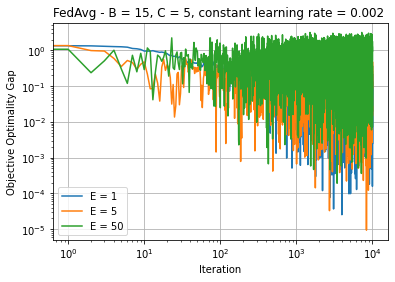

In [ ]:
B = 15
C = 5
E = [1, 5, 50]
optimality_gap = [FedAVg(B, C, E[i], x_m_points, X, Y, sigma_squared, nu, a, step_const, f_star, 10000)[0] for i in range(3)]

for i, optimality_gaps in enumerate(optimality_gap):
    plt.plot(range(10000), optimality_gaps, label=f"E = {E[i]}")
plt.xlabel('Iteration')
plt.ylabel('Objective Optimality Gap')
plt.title(f'FedAvg - B = {B}, C = {C}, constant learning rate = 0.002 ')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

 14%|█▍        | 1396/10000 [00:19<02:09, 66.69it/s]/Users/aconrad/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 16%|█▌        | 1584/10000 [04:46<27:05,  5.18it/s]/var/folders/l0/5qk3mw253y945myr_1tfc8z00000gn/T/ipykernel_32189/1022160500.py:10: RuntimeWarning: invalid value encountered in subtract
  al -= step_size(k)*grad
100%|██████████| 10000/10000 [34:45<00:00,  4.79it/s]  
/Users/aconrad/opt/anaconda3/lib/python3.9/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


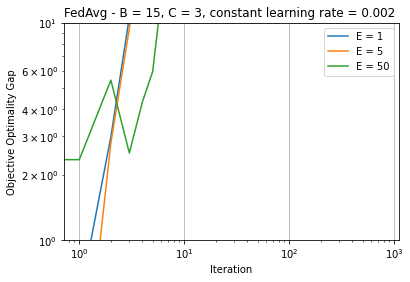

In [ ]:
B = 15
C = 3
E = [1, 5, 50]
optimality_gap = [FedAVg(B, C, E[i], x_m_points, X, Y, sigma_squared, nu, a, step_const, f_star, 10000)[0] for i in range(3)]

for i, optimality_gaps in enumerate(optimality_gap):
    plt.plot(range(10000), optimality_gaps, label=f"E = {E[i]}")
plt.xlabel('Iteration')
plt.ylabel('Objective Optimality Gap')
plt.title(f'FedAvg - B = {B}, C = {C}, constant learning rate = 0.002 ')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

## Part III

In [ ]:
epsilon = [0.1, 1, 10]

In [ ]:
def nu_(eps, k):
    return (0.01/eps)*(1/(1 + 0.001*(k**0.1)))
def al(k): 
    return 0.002/(1 + 0.001*k)

def ga(k):
    return 1/(1 + 0.001*(k**0.9))

In [ ]:
def DGD_DP(X, X_selected, y, sigma_squared, nu, a, num_iterations, alpha_star, W, eps):
    m = X_selected.shape[0]
    n = X.shape[0]
    agents_data_indices = np.array_split(np.random.permutation(n), a)
    # each agent should have n/a=100/5=20 points
    #print("agents_data_indices:",agents_data_indices)
    alpha = [np.ones((m, 1)) for _ in range(a)] # Initialize local variables for each agent
    new_alpha = [np.ones((m, 1)) for _ in range(a)]
    all_optimality_gaps = [[] for _ in range(a)]  # Store optimality gaps for each agent
    all_alpha = [[] for _ in range(a)]  # Store alpha at each iteration
    K_mm = compute_kernel_matrix(X_selected, X_selected)
    #nu_k = [nu_(eps,k) for k in range(num_iterations)]
    #al_k = [al(k) for k in range(num_iterations)]
    #ga_k = [ga(k) for k in range(num_iterations)]
    #Knm = compute_kernel_matrix(X, X_selected)
    for k in tqdm(range(num_iterations)):
        for i, data_indices in enumerate(agents_data_indices):
            # Select data and compute local variables
            X_local = X[data_indices]
            y_local = y[data_indices].reshape(-1, 1)
            K_im = compute_kernel_matrix(X_local, X_selected)
            alpha_agent = alpha[i]
            #print(K_mm.shape,alpha_agent.shape, K_im.shape, y_local.shape, np.dot(K_im, alpha_agent).shape)
            gr = (sigma_squared/5)*np.dot(K_mm, alpha_agent) + np.dot(K_im.T, np.dot(K_im, alpha_agent) - y_local) + (nu/5)*alpha_agent
            hat_W = W - np.eye(a)
            gamma = np.random.laplace(0, nu_(eps,k), a)
            for j in range(a):
                if hat_W[i,j] > 0 and i != j:
                    new_alpha[i] += ga(k)*hat_W[i,j]*(alpha[j] + gamma[j] - alpha[i])
            new_alpha[i] -= al(k)*gr
        alpha = new_alpha
        for agent_idx in range(a):
            alpha_agent = alpha[agent_idx]
            optimality_gap = np.linalg.norm(alpha_agent - alpha_star.reshape(-1, 1))
            all_optimality_gaps[agent_idx].append(optimality_gap)
            all_alpha[agent_idx].append(alpha_agent)

    return all_optimality_gaps, all_alpha

100%|██████████| 20000/20000 [01:28<00:00, 225.36it/s]


0 all graphs done


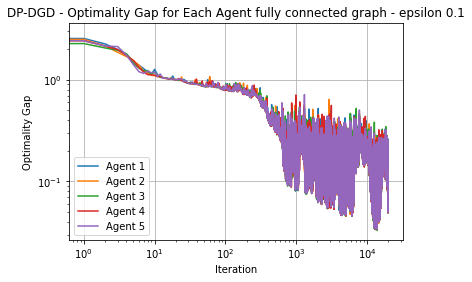

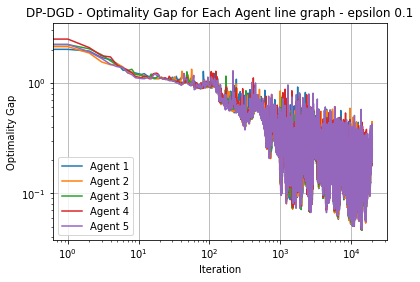

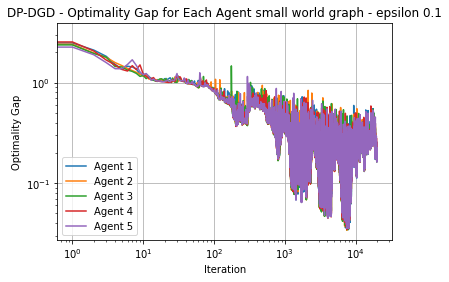

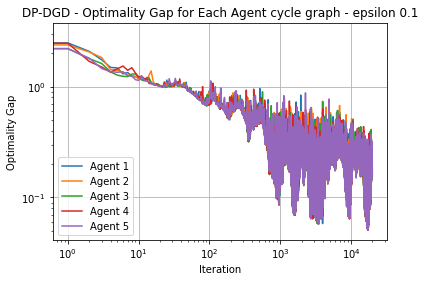

100%|██████████| 20000/20000 [01:28<00:00, 225.79it/s]


1 all graphs done


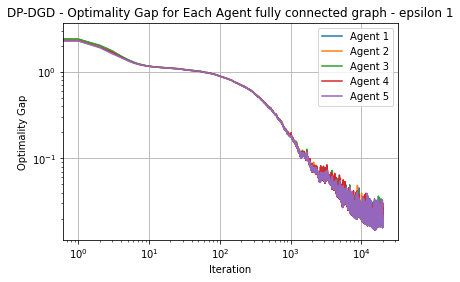

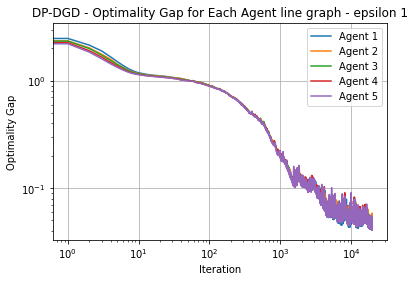

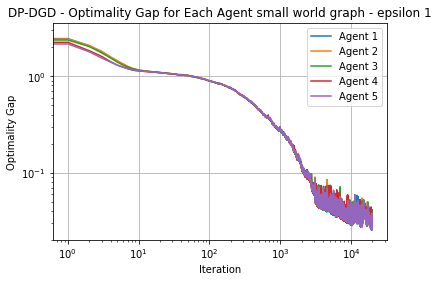

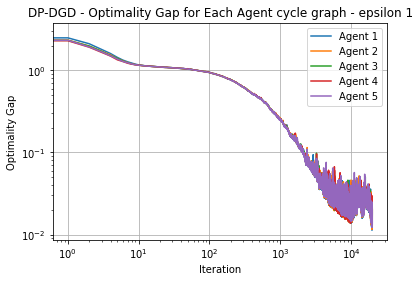

100%|██████████| 20000/20000 [01:28<00:00, 226.51it/s]


2 all graphs done


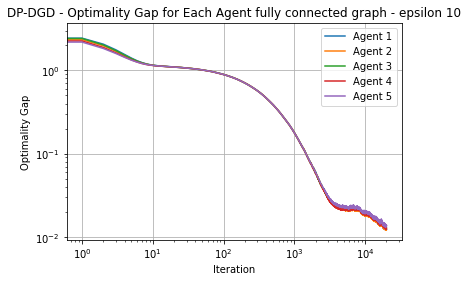

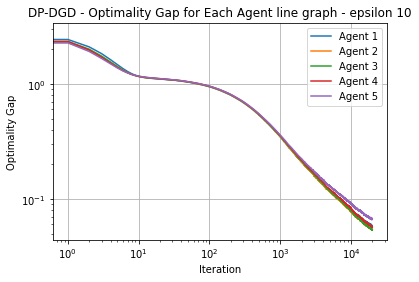

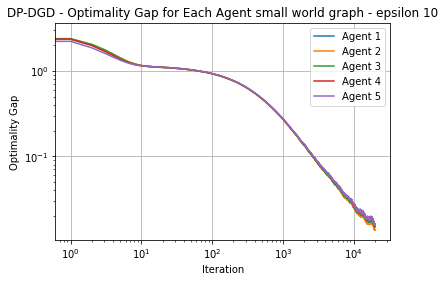

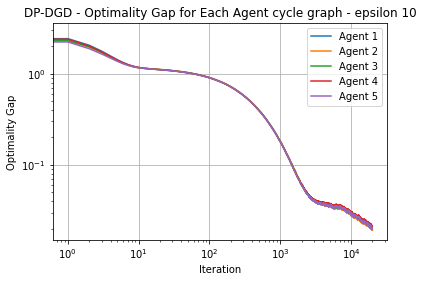

In [ ]:
for i in range(3):
    eps = epsilon[i]
    optimality_gap_fc,alpha_fc = DGD_DP(x, x_selected, y, sigma_squared, nu, a, num_iterations, alpha_star, fc_graph, eps)
    #print("fully connected graph done")
    optimality_gap_line,alpha_line = DGD_DP(x, x_selected, y, sigma_squared, nu, a, num_iterations, alpha_star,line_graph, eps)
    #print("line graph done")
    optimality_gap_small_world,alpha_small_world = DGD_DP(x, x_selected, y, sigma_squared, nu, a, num_iterations, alpha_star, small_world_graph, eps)
    #print("small world graph done")
    optimality_gap_cycle,alpha_cycle = DGD_DP(x, x_selected, y, sigma_squared, nu, a, num_iterations, alpha_star, cycle_graph, eps)
    #print("cycle graph done")
    print(i, "all graphs done")
    for agent_idx, optimality_gaps in enumerate(optimality_gap_fc):
        plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")
    plt.xlabel('Iteration')
    plt.ylabel('Optimality Gap')
    plt.title(f'DP-DGD - Optimality Gap for Each Agent fully connected graph - epsilon = {eps}')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

    for agent_idx, optimality_gaps in enumerate(optimality_gap_line):
        plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

    plt.xlabel('Iteration')
    plt.ylabel('Optimality Gap')
    plt.title(f'DP-DGD - Optimality Gap for Each Agent line graph - epsilon = {eps}')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

    for agent_idx, optimality_gaps in enumerate(optimality_gap_small_world):
        plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

    plt.xlabel('Iteration')
    plt.ylabel('Optimality Gap')
    plt.title(f'DP-DGD - Optimality Gap for Each Agent small world graph - epsilon = {eps}')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

    for agent_idx, optimality_gaps in enumerate(optimality_gap_cycle):
        plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

    plt.xlabel('Iteration')
    plt.ylabel('Optimality Gap')
    plt.title(f'DP-DGD - Optimality Gap for Each Agent cycle graph - epsilon = {eps}')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.show()